In [1]:
import os, sys

# TODO: set this to the root of the platonic-rep repo on your machine
REPO_ROOT = "/orcd/data/ngk/001/users/gracehu/platonic-rep"

os.chdir(REPO_ROOT)
sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())

CWD: /orcd/data/ngk/001/users/gracehu/platonic-rep


## imports and config

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tasks import get_models
from utils import to_feature_filename

# ===== Config =====
dataset = "minhuh/prh"
subset = "wit_1024"
modelset = "val"

# language feature extraction options you used
lang_pool = "avg"
lang_prompt = False
caption_idx = 0  # change if you used a different caption index

# vision feature extraction options you used
vision_pool = "cls"
vision_prompt = False

#imggpt feature extraction options used
imggpt_pool = "None"
imggpt_prompt = False

# which DINOv2 model to use on the y-axis
# must be in the vision model list for `modelset`
DINO_NAME = "vit_giant_patch14_dinov2.lvd142m"  # e.g. giant model

# where features + alignment results are stored (defaults from repo)
FEATURE_DIR = "./results/features"
ALIGN_DIR = "./results/alignment"

# Get the list of language, vision models in this modelset
llm_models, lvm_models, gpt_models = get_models(modelset, modality="all")

print("Language models:")
for m in llm_models:
    print("  ", m)

print("\nVision models:")
for m in lvm_models:
    print("  ", m)

print("\nGPT models:")
for m in gpt_models:
    print(" ", m)

print("Config OK")


hi
Language models:
   bigscience/bloomz-560m
   bigscience/bloomz-1b1
   bigscience/bloomz-1b7
   bigscience/bloomz-3b
   bigscience/bloomz-7b1
   openlm-research/open_llama_3b
   openlm-research/open_llama_7b
   openlm-research/open_llama_13b
   huggyllama/llama-7b
   huggyllama/llama-13b

Vision models:
   vit_tiny_patch16_224.augreg_in21k
   vit_small_patch16_224.augreg_in21k
   vit_base_patch16_224.augreg_in21k
   vit_large_patch16_224.augreg_in21k
   vit_base_patch16_224.mae
   vit_large_patch16_224.mae
   vit_huge_patch14_224.mae
   vit_small_patch14_dinov2.lvd142m
   vit_base_patch14_dinov2.lvd142m
   vit_large_patch14_dinov2.lvd142m
   vit_giant_patch14_dinov2.lvd142m
   vit_base_patch16_clip_224.laion2b
   vit_large_patch14_clip_224.laion2b
   vit_huge_patch14_clip_224.laion2b
   vit_base_patch16_clip_224.laion2b_ft_in12k
   vit_large_patch14_clip_224.laion2b_ft_in12k
   vit_huge_patch14_clip_224.laion2b_ft_in12k

GPT models:
  openai/imagegpt-small
  openai/imagegpt-medium
 

## Load model lists and alignment scores

In [10]:
# Find index of the chosen DINOv2 model
assert DINO_NAME in lvm_models, f"{DINO_NAME} not found in lvm_models"
dino_idx = lvm_models.index(DINO_NAME)
print(f"\nUsing DINOv2 model: {DINO_NAME} (index {dino_idx})")

# Path to the alignment file produced by measure_alignment.py
# Adjust this if your directory structure differs.
align_path = os.path.join(
    ALIGN_DIR,
    dataset,
    modelset,
    f"language_pool-{lang_pool}_prompt-{lang_prompt}_"
    f"vision_pool-{vision_pool}_prompt-{vision_prompt}",
    "mutual_knn_k10_paperres.npy",
)

print("Loading alignment from:", align_path)
align_result = np.load(align_path, allow_pickle=True).item()

scores = align_result["scores"]  # shape: [num_llms, num_lvms]
print("Alignment scores shape:", scores.shape)

# Alignment to the chosen DINOv2 model: one scalar per language model
alignment_to_dino = scores[:, dino_idx]
alignment_to_dino


Using DINOv2 model: vit_giant_patch14_dinov2.lvd142m (index 10)
Loading alignment from: ./results/alignment/minhuh/prh/val/language_pool-avg_prompt-False_vision_pool-cls_prompt-False/mutual_knn_k10_paperres.npy
Alignment scores shape: (10, 17)


array([0.10644531, 0.11269531, 0.11689453, 0.12119141, 0.13095704,
       0.15537108, 0.15898438, 0.16201171, 0.16113281, 0.15927735])

## Check indices (layer with best alignment)

In [69]:
# Find index of the chosen DINOv2 model
assert DINO_NAME in lvm_models, f"{DINO_NAME} not found in lvm_models"
dino_idx = lvm_models.index(DINO_NAME)
print(f"\nUsing DINOv2 model: {DINO_NAME} (index {dino_idx})")


# Path to the alignment file produced by measure_alignment.py
# Adjust this if your directory structure differs.
align_path = os.path.join(
    ALIGN_DIR,
    dataset,
    modelset,
    f"language_pool-{lang_pool}_prompt-{lang_prompt}_"
    f"vision_pool-{vision_pool}_prompt-{vision_prompt}",
    "mutual_knn_k10_paperres.npy",
)

print("Loading alignment from:", align_path)
align_result = np.load(align_path, allow_pickle=True).item()
indices = align_result["indices"]  # shape: [num_llms, num_lvms]
print("Alignment indices shape:", indices.shape)

# Alignment to the chosen DINOv2 model: one scalar per language model
alignment_to_dino = indices[:, dino_idx]
alignment_to_dino



Using DINOv2 model: vit_giant_patch14_dinov2.lvd142m (index 10)
Loading alignment from: ./results/alignment/minhuh/prh/val/language_pool-avg_prompt-False_vision_pool-cls_prompt-False/mutual_knn_k10_paperres.npy
dict_keys(['scores', 'indices'])
Alignment indices shape: (10, 17, 2)


array([[34., 23.],
       [34., 23.],
       [36., 23.],
       [37., 27.],
       [36., 29.],
       [37., 23.],
       [35., 27.],
       [36., 35.],
       [35., 25.],
       [36., 29.]])

## Load bits-per-byte and compute language performance

In [44]:
bpb_list = []

for m in llm_models:
    # Build feature filename for each language model
    feat_path = to_feature_filename(
        FEATURE_DIR,
        dataset,
        subset,
        m,
        pool=lang_pool,
        prompt=lang_prompt,
        caption_idx=caption_idx,
    )

    if not os.path.exists(feat_path):
        raise FileNotFoundError(f"Feature file not found for {m} at {feat_path}")

    data = torch.load(feat_path, map_location="cpu")

    if "bpb" not in data:
        raise KeyError(f"'bpb' not found in feature file for {m}")

    bpb_value = data["bpb"].item()
    bpb_list.append(bpb_value)
    print(f"{m}: bpb = {bpb_value:.4f}")

bpb = np.array(bpb_list)

# Language performance metric = 1 - bits-per-byte (as in the paper)
lang_perf = 1.0 - bpb
print(lang_perf.shape)

print("\nLanguage performance (1 - bpb):")
for m, p in zip(llm_models, lang_perf):
    print(f"{m}: {p:.4f}")

bigscience/bloomz-560m: bpb = 2.0766
bigscience/bloomz-1b1: bpb = 1.8847
bigscience/bloomz-1b7: bpb = 1.9390
bigscience/bloomz-3b: bpb = 1.8948
bigscience/bloomz-7b1: bpb = 1.8394
openlm-research/open_llama_3b: bpb = 1.7194
openlm-research/open_llama_7b: bpb = 1.6774
openlm-research/open_llama_13b: bpb = 1.6558
huggyllama/llama-7b: bpb = 1.6477
huggyllama/llama-13b: bpb = 1.6205
(10,)

Language performance (1 - bpb):
bigscience/bloomz-560m: -1.0766
bigscience/bloomz-1b1: -0.8847
bigscience/bloomz-1b7: -0.9390
bigscience/bloomz-3b: -0.8948
bigscience/bloomz-7b1: -0.8394
openlm-research/open_llama_3b: -0.7194
openlm-research/open_llama_7b: -0.6774
openlm-research/open_llama_13b: -0.6558
huggyllama/llama-7b: -0.6477
huggyllama/llama-13b: -0.6205


# Plot language performance vs vision alignment

## Make the scatter plot (performance vs alignment to DINOv2)

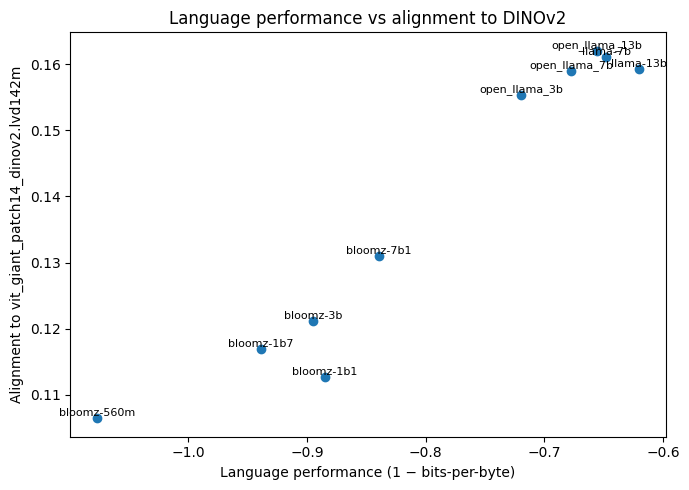

In [16]:
plt.figure(figsize=(7, 5))

plt.scatter(lang_perf, alignment_to_dino)

# optional: label each point with a short model name
for x, y, name in zip(lang_perf, alignment_to_dino, llm_models):
    short_name = name.split("/")[-1]  # strip HF org if present
    plt.text(x, y, short_name, fontsize=8, ha="center", va="bottom")

plt.xlabel("Language performance (1 − bits-per-byte)")
plt.ylabel(f"Alignment to {DINO_NAME}")
plt.title("Language performance vs alignment to DINOv2")
plt.tight_layout()
plt.show()

## align to any vision model

In [48]:
def plot_alignment_to_vision(
    align_path: str,
    model_names,                 # can be str or list of str
    llm_models,
    align_models,
    lang_perf: np.ndarray,
    annotate: bool = True,
    figsize=(7, 5),
):

    """
    Plot language performance vs alignment to one or more vision models.

    Args:
        align_path: Path to the saved alignment result (npz or npy dict-like).
        model_names: Name or list of names of vision models as in align_models.
        llm_models: List of language model names (len = num_llms).
        align_models: List of vision model names (len = num_lvms).
        scores: Unused; will be read from align_path for consistency.
        lang_perf: 1D array of shape (num_llms,), e.g. 1 - bpb.
        annotate: If True, label each point with a short LM name.
        figsize: Figure size for the plot.
    """

    # Allow single string or list
    if isinstance(model_names, str):
        model_names = [model_names]

    # Validate that all requested models exist
    missing = [m for m in model_names if m not in align_models]
    if missing:
        # try to be helpful: show close matches for the first missing one
        m0 = missing[0]
        candidates = [m for m in align_models if m0 in m or m in m0]
        msg = f"{m0!r} not found in align_models."
        print("Available align_models:", align_models)
        if candidates:
            msg += f" Did you mean one of: {candidates}?"
        raise ValueError(msg)

    print("Loading alignment from:", align_path)
    align_result = np.load(align_path, allow_pickle=True).item()
    scores = align_result["scores"]  # shape: [num_llms, num_lvms]

    plt.figure(figsize=figsize)

    # Plot each requested vision model in a different color (default color cycle)
    for model_name in model_names:
        v_idx = align_models.index(model_name)
        alignment = scores[:, v_idx]  # alignment to this vision model for each LM
        
        plt.scatter(lang_perf, alignment, label=model_name)

        if annotate:
            for x, y, name in zip(lang_perf, alignment, llm_models):
                short_name = name.split("/")[-1]  # strip HF org if present
                plt.text(x, y, short_name, fontsize=8, ha="center", va="bottom")

    plt.xlabel("Language performance (1 − bits-per-byte)")
    if len(model_names) == 1:
        plt.ylabel(f"Alignment to {model_names[0]}")
        plt.title(f"LM performance vs alignment to {model_names[0]}")
    else:
        plt.ylabel("Alignment to vision models")
        pretty_list = ", ".join(model_names)
        plt.title(f"LM performance vs alignment to [{pretty_list}]")

    plt.legend(title="Vision model")
    plt.tight_layout()
    plt.show()

Loading alignment from: ./results/alignment/minhuh/prh/val/language_pool-avg_prompt-False_imggpt_pool-None_prompt-False/mutual_knn_k10.npy


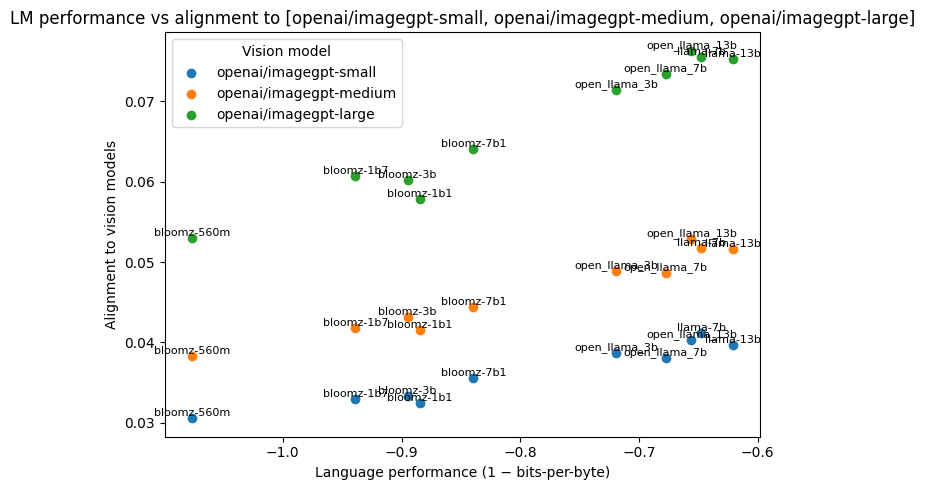

In [49]:
# or CLIP ViT-B/32 if it's in your modelset
align_path = os.path.join(
    ALIGN_DIR,
    dataset,
    modelset,
    f"language_pool-{lang_pool}_prompt-{lang_prompt}_"
    f"imggpt_pool-{imggpt_pool}_prompt-{imggpt_prompt}",
    "mutual_knn_k10.npy",
)
plot_alignment_to_vision(
    align_path,
    ["openai/imagegpt-small", "openai/imagegpt-medium","openai/imagegpt-large"],
    llm_models,
    gpt_models,
    lang_perf,
)


# Plot Vision performance vs alignment

## Load bits-per-pixel  and compute vision performance

In [56]:
bpp_list = []

for m in lvm_models:
    # Build feature filename for each language model
    feat_path = to_feature_filename(
        FEATURE_DIR,
        dataset,
        subset,
        m,
        pool=vision_pool,
        prompt=vision_prompt,
        caption_idx=caption_idx,
    )

    if not os.path.exists(feat_path):
        raise FileNotFoundError(f"Feature file not found for {m} at {feat_path}")

    data = torch.load(feat_path, map_location="cpu")

    if "bpp" not in data:
        raise KeyError(f"'bpp' not found in feature file for {m}")

    bpp_value = torch.mean(data["bpp"]).item()
    bpp_list.append(bpp_value)
    print(f"{m}: bpb = {bpp_value:.4f}")

bpp = np.array(bpp_list)

# Vision performance metric = 1 - bits-per-byte (as in the paper)
vis_perf = 1.0 - bpp
print(vis_perf.shape)

print("\nVision Performance (1 - bpp):")
for m, p in zip(lvm_models, vis_perf):
    print(f"{m}: {p:.4f}")

vit_tiny_patch16_224.augreg_in21k: bpb = 0.3345
vit_small_patch16_224.augreg_in21k: bpb = 0.3105
vit_base_patch16_224.augreg_in21k: bpb = 0.4396
vit_large_patch16_224.augreg_in21k: bpb = 0.3202
vit_base_patch16_224.mae: bpb = 0.3722
vit_large_patch16_224.mae: bpb = 0.3460
vit_huge_patch14_224.mae: bpb = 0.3720
vit_small_patch14_dinov2.lvd142m: bpb = 0.1662
vit_base_patch14_dinov2.lvd142m: bpb = 0.1595
vit_large_patch14_dinov2.lvd142m: bpb = 0.1468
vit_giant_patch14_dinov2.lvd142m: bpb = 0.1669
vit_base_patch16_clip_224.laion2b: bpb = 0.3084
vit_large_patch14_clip_224.laion2b: bpb = 0.0671
vit_huge_patch14_clip_224.laion2b: bpb = 0.2875
vit_base_patch16_clip_224.laion2b_ft_in12k: bpb = 0.3705
vit_large_patch14_clip_224.laion2b_ft_in12k: bpb = 0.0790
vit_huge_patch14_clip_224.laion2b_ft_in12k: bpb = 0.3051
(17,)

Vision Performance (1 - bpp):
vit_tiny_patch16_224.augreg_in21k: 0.6655
vit_small_patch16_224.augreg_in21k: 0.6895
vit_base_patch16_224.augreg_in21k: 0.5604
vit_large_patch16_22

## plot alignment to language

In [65]:
def plot_alignment_to_language(
    align_path: str,
    model_names,                 # can be str or list of str
    lvm_models,
    align_models,
    vis_perf: np.ndarray,
    annotate: bool = True,
    figsize=(7, 5),
):

    """
    Plot lvm performance vs alignment to one or more language models.

    Args:
        align_path: Path to the saved alignment result (npz or npy dict-like).
        model_names: Name or list of names of vision models as in align_models.
        llm_models: List of language model names (len = num_llms).
        align_models: List of vision model names (len = num_lvms).
        scores: Unused; will be read from align_path for consistency.
        lang_perf: 1D array of shape (num_llms,), e.g. 1 - bpb.
        annotate: If True, label each point with a short LM name.
        figsize: Figure size for the plot.
    """

    # Allow single string or list
    if isinstance(model_names, str):
        model_names = [model_names]

    # Validate that all requested models exist
    missing = [m for m in model_names if m not in align_models]
    if missing:
        # try to be helpful: show close matches for the first missing one
        m0 = missing[0]
        candidates = [m for m in align_models if m0 in m or m in m0]
        msg = f"{m0!r} not found in align_models."
        print("Available align_models:", align_models)
        if candidates:
            msg += f" Did you mean one of: {candidates}?"
        raise ValueError(msg)

    print("Loading alignment from:", align_path)
    align_result = np.load(align_path, allow_pickle=True).item()
    scores = align_result["scores"]  # shape: [num_llms, num_lvms]

    plt.figure(figsize=figsize)

    # Plot each requested language model in a different color (default color cycle)
    for model_name in model_names:
        print(model_name)
        v_idx = align_models.index(model_name)
        alignment = scores[:, v_idx]  # alignment to this vision model for each LM
        
        plt.scatter(vis_perf, alignment, label=model_name)

        if annotate:
            for x, y, name in zip(lang_perf, alignment, lvm_models):
                short_name = name.split("/")[-1]  # strip HF org if present
                plt.text(x, y, short_name, fontsize=8, ha="center", va="bottom")

    plt.xlabel("Vision performance (1 − bits-per-pixel)")
    if len(model_names) == 1:
        plt.ylabel(f"Alignment to {model_names[0]}")
        plt.title(f"LM performance vs alignment to {model_names[0]}")
    else:
        plt.ylabel("Alignment to Language models")
        pretty_list = ", ".join(model_names)
        plt.title(f"LM performance vs alignment to [{pretty_list}]")

    plt.legend(title="Language model")
    plt.tight_layout()
    plt.show()

Loading alignment from: ./results/alignment/minhuh/prh/val/language_pool-avg_prompt-False_vision_pool-cls_prompt-False/mutual_knn_k10.npy
huggyllama/llama-13b
openlm-research/open_llama_13b


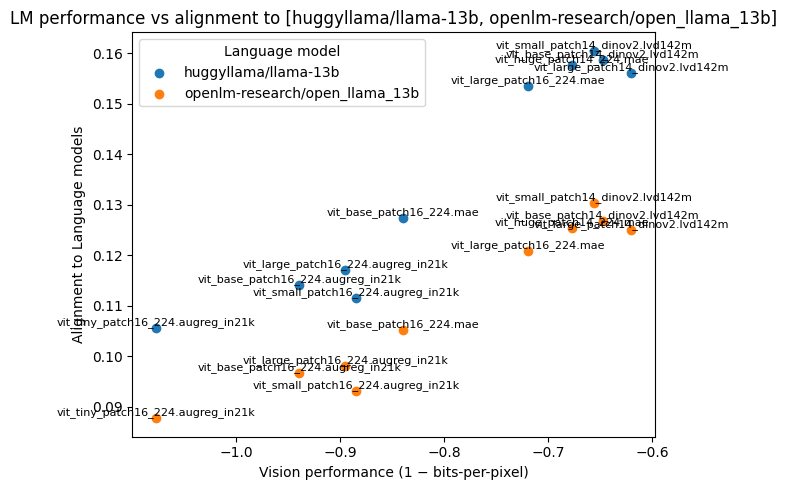

In [66]:
# Path to the alignment file produced by measure_alignment.py
# Adjust this if your directory structure differs.
align_path = os.path.join(
    ALIGN_DIR,
    dataset,
    modelset,
    f"language_pool-{lang_pool}_prompt-{lang_prompt}_"
    f"vision_pool-{vision_pool}_prompt-{vision_prompt}",
    "mutual_knn_k10.npy",
)
plot_alignment_to_language(
    align_path,
    ["huggyllama/llama-13b", "openlm-research/open_llama_13b"],
    lvm_models,
    llm_models,
    lang_perf,
)
